In [ ]:
"""          Load The Data      """

import pandas as pd
import numpy as np
# Load pickled data
import pickle

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

train_sizes, train_coords = train['sizes'], train['coords']
valid_sizes, valid_coords = valid['sizes'], valid['coords']
test_sizes, test_coords = test['sizes'], test['coords']


print("Done importing images.")


Done importing images.


In [ ]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

In [ ]:

"""           Dataset Summary & Exploration      """
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of a traffic sign image?
image_shape =  X_train.shape[1:]

# numbre of classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
### Data exploration visualization .
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline


In [ ]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print()
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 809 min 180 max 2010

Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


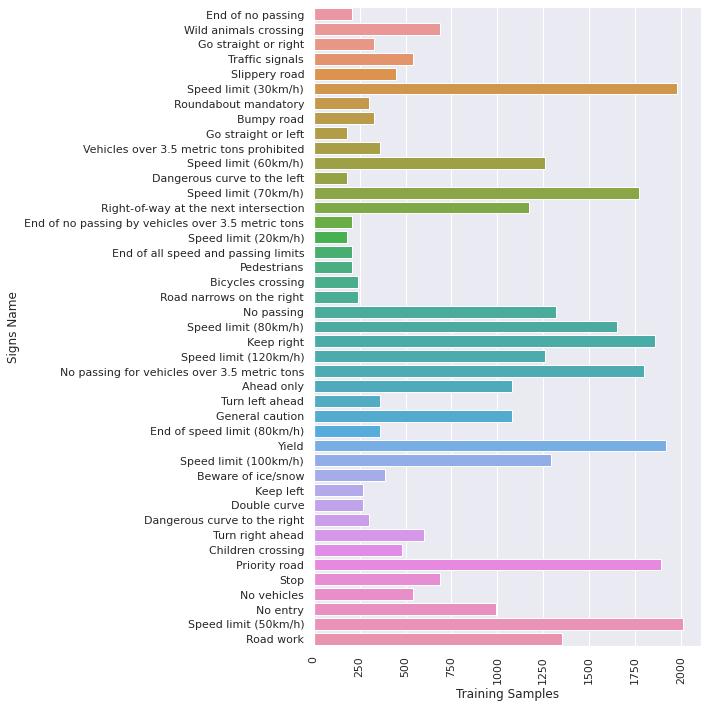

In [ ]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.barplot(data=counts,x='training_samples_count',y='sign')
plt.xticks(rotation=90)
plt.ylabel('Signs Name')
plt.xlabel('Training Samples');
plt.tight_layout()
#plt.savefig('training_set_counts.png')

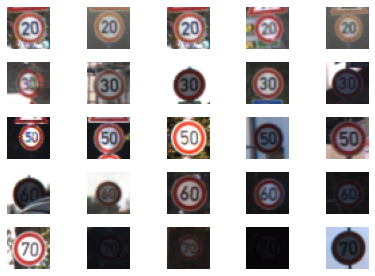

In [ ]:
def get_random_samples(n_max=1):
    selected = list()
    
    for current_label in range(5):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  5*n_max
    return list(selected)

    plt.figure(figsize=(12, 16))
count=0
cols = 5
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(5,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.tight_layout()
#plt.savefig('random_examples.png')

In [19]:
"""  Pre-process the Data Set   """
import cv2

#generate some random image
def someRandomImageId(nb = n_train):
    return int(np.random.rand()*nb)


#normalize the data using (pixel - 128)/ 128 
def normalize_features_pos(img_):
    return (img_.astype(np.float32) - 128.) / 128.


def rectifyCoords(nb, sizes, coords):
    rectified = []
    for j in range(0, nb):
        x_ratio = image_shape[1] / sizes[j][0]
        y_ratio = image_shape[2] / sizes[j][1]
        rectified.append((int(coords[j][0]*x_ratio), int(coords[j][1]*y_ratio), \
                          int(coords[j][2]*x_ratio), int(coords[j][3]*y_ratio)))
    return rectified


#resize image
def resizeSize(img, x=32, y=32):
    return cv2.resize(img,(x, y), interpolation = cv2.INTER_CUBIC).astype(np.uint8)

def crop(img, ROI):
    return img[(ROI[1]):(ROI[3]),(ROI[0]):(ROI[2])]

#Add a region of interset
def addROI(img, ROI, color=(0, 255, 0)):
    copy = X_train[i].copy()
    return cv2.rectangle(copy,(ROI[0],ROI[1]),(ROI[2],ROI[3]),color)

#rotate randomly the images by a small angle [-15°, 15°] 
def rotateImage(image, ROI, angle=None):
    if angle == None:
        angle = np.random.rand()*30-15
    image_center = ((ROI[2]-ROI[0])/2+ROI[0], (ROI[3]-ROI[1])/2+ROI[1])
    rot_mat = cv2.getRotationMatrix2D(image_center,angle,1.0)
    result = cv2.warpAffine(image, rot_mat, dsize=image.shape[0:2],flags=cv2.INTER_LINEAR)
    return result

rectified_train_coords = rectifyCoords(n_train, train_sizes, train_coords)
rectified_valid_coords = rectifyCoords(n_validation, valid_sizes, valid_coords)
rectified_test_coords  = rectifyCoords(n_test,  test_sizes,  test_coords)

def plotAugmentation(*argv, figsize=(20, 5)):
    fig = plt.figure(figsize=figsize)
    for i in range(0, len(argv[0])):    
        ax=fig.add_subplot(1,len(argv[0]),i+1)        
        ax.imshow(argv[0][i][1])
        ax.set_title(argv[0][i][0])
    plt.show() 

print("Augmenting functions defined.")

Augmenting functions defined.


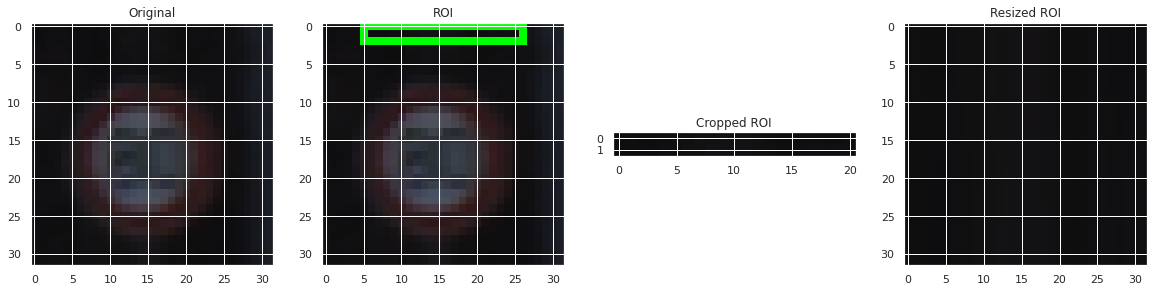

In [20]:
#ROI

i = someRandomImageId()
cropped = crop(X_train[i], rectified_train_coords[i])
arguments = (('Original', X_train[i]), ('ROI', addROI(X_train[i], rectified_train_coords[i])), ('Cropped ROI', cropped), ('Resized ROI', resizeSize(cropped)))
plotAugmentation(arguments)